# Determine I-V curve nonlinearity functions

In [ ]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit

%matplotlib inline

## Generate I-V Curves

### Sodium Channels

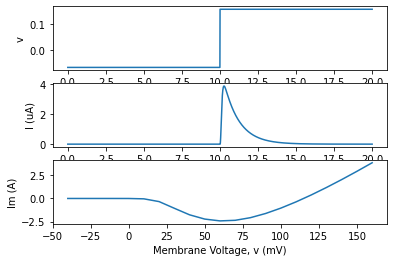

In [9]:
# IV curve for HH Sodium ion channel <- using

start_scope()

defaultclock.dt = 0.01*ms

El = 10.613*mV
ENa = 115*mV
EK = -70*mV
gl = 0.3*msiemens
gNa0 = 120*msiemens
gK = 36*msiemens


eqs = '''
# The same equations for the whole neuron, but possibly different parameter values
# distributed transmembrane current
Im = gNa * m**3 * h * (v-ENa) : amp
I : amp # applied current
dm/dt = alpham * (1-m) - betam * m : 1
dh/dt = alphah * (1-h) - betah * h : 1

alpham = (0.1/mV) * 10*mV/exprel((-v+25*mV)/(10*mV))/ms : Hz
betam = 4 * exp(-v/(18*mV))/ms : Hz
alphah = 0.07 * exp(-v/(20*mV))/ms : Hz
betah = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms : Hz

gNa : siemens
v : volt

'''

# Change to Euler method because exact integrator doesn't work here
G = NeuronGroup(1, eqs, method='euler')
M = StateMonitor(G, ['v','Im'], record=0)

v0 = -70*mV
G.v = v0
G.h = 1
G.m = 0
G.I = 0*amp
G.gNa = gNa0

v_array = np.linspace(-40, 160, num=21)

# Snapshot the state
store()

peak_currents = []
trough_currents = []
for i, v_trial in enumerate(v_array):
    restore()  # Restore the initial state
    
    # Run simulation
    run(10*ms)
    G.v = v_trial*mV
    run(10*ms)
    
    # store the results
    peak = max(M.Im[0])
    trough = min(M.Im[0])
    if abs(peak) < abs(trough):
        peak_currents.append(trough)
    else:
        peak_currents.append(peak)

# print(max(M.Im[0]))
subplot(311)
plot(M.t/ms, M.v[0])
ylabel('v')
subplot(312)
plot(M.t/ms, M.Im[0]/mA)
xlabel('Time (ms)')
ylabel('I (uA)')
subplot(313)
plot(v_array, peak_currents/mA)
xlabel('Membrane Voltage, v (mV)')
ylabel('Im (A)')

show()

[8.78821446e-02 1.13683916e+02 6.38609814e+00 8.97669998e+00]


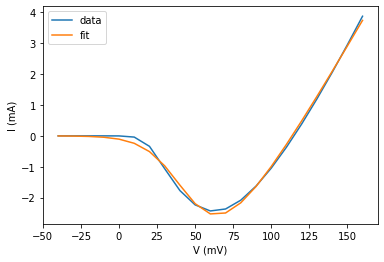

In [10]:
# Fit curve to HH sodium IV plot

v_array = np.linspace(-40, 160, num=21)
Im_array = peak_currents/mA

def f_Na(v, a, b, c, d):
    return(a*(v-b)/(1+exprel((c - v/d))))
           


seed(seed=100)

popt, pcov = curve_fit(f_Na, v_array, Im_array, method='trf')
print(popt)
plt.plot(v_array, Im_array)
plt.plot(v_array, f_Na(v_array, *popt))
plt.xlabel('V (mV)')
plt.ylabel('I (mA)')
plt.legend(['data','fit'])


### Potassium Channels

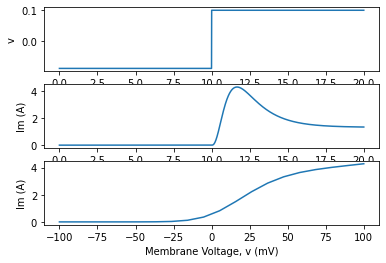

In [12]:
# IV curve for Kv3.3 Potassium ion channel
# Doiron 2001

start_scope()

defaultclock.dt = 0.01*ms


El = 10.613*mV
ENa = 67*mV
EK = -88.5*mV
ECa = 123*mV
gl = 0.3*msiemens
gNa0 = 120*msiemens
gK0 = 100*msiemens

# Typical equations
eqs = '''
# The same equations for the whole neuron, but possibly different parameter values
# distributed transmembrane current
Im = gK * m**3 * h * (v-EK) : amp
I : amp
v : volt
dm/dt = alpham * (1-m) - betam * m : 1
dh/dt = alphah * (1-h) - betah * h : 1
alpham = m_inf/tau_m/ms : Hz
betam = (1-m_inf)/tau_m/ms : Hz
alphah = h_inf/tau_h/ms : Hz
betah = (1-h_inf)/tau_h/ms : Hz

m_inf = 1/(1 + exp(-(v)/(19.00*mV))) : 1
tau_m = 0.8 : 1
h_inf = 1/(1 + exp(-(v - (-3*mV)) / (-40.00*mV))) : 1
tau_h = 1.5 : 1


gK : siemens
'''
# Change to Euler method because exact integrator doesn't work here
G = NeuronGroup(1, eqs, method='exact')
M = StateMonitor(G, ['v','Im'], record=0)

v0 = EK
G.v = v0
G.m = 0
G.h = 1
G.I = 0*amp
G.gK = gK0

v_array = np.linspace(-100,100, num=20)

# Snapshot the state
store()

peak_currents = []
trough_currents = []
for i, v_trial in enumerate(v_array):
    restore()  # Restore the initial state
    
    # Run simulation
    run(10*ms)
    G.v = v_trial*mV
    run(10*ms)
#     G.v = v0
#     run(10*ms)
    
    # store the results
    peak = max(M.Im[0])
    trough = min(M.Im[0])
    if abs(peak) < abs(trough):
        peak_currents.append(trough)
    else:
        peak_currents.append(peak)

# print(max(M.Im[0]))
subplot(311)
plot(M.t/ms, M.v[0])
ylabel('v')
subplot(312)
plot(M.t/ms, M.Im[0]/mA)
xlabel('Time (ms)')
ylabel('Im (A)')
subplot(313)
plot(v_array, peak_currents/mA)
xlabel('Membrane Voltage, v (mV)')
ylabel('Im (A)')

show()

[ 2.23043453  0.13197605 16.67048059  0.4325509 ]


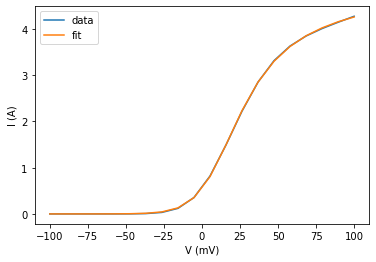

In [13]:
# Fit curve to Kv3.3 (Doiron 2001) IV plot

v_array = np.linspace(-100,100, num=20)
Im_array = peak_currents/mA

# def f_K(v, a, b, c):
#     lin = b*v + c
#     lin[lin < a] = a
#     return(lin)
        
def f_K (v, a, b, c,d):
    return(a/(d+exprel(-b*(v-c))))
           


seed(seed=100)

popt, pcov = curve_fit(f_K, v_array, Im_array, method='trf')
print(popt)
plt.plot(v_array, Im_array)
plt.plot(v_array, f_K(v_array, *popt))
plt.xlabel('V (mV)')
plt.ylabel('I (A)')
plt.legend(['data','fit'])

### Calcium Channels

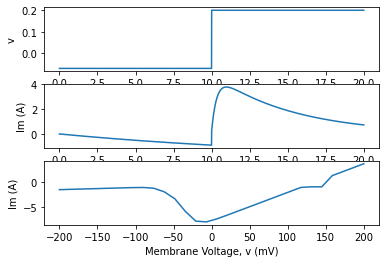

In [14]:
# IV curve for Cav3.2 Potassium ion channel <- using
# Miyasho 2001

start_scope()

defaultclock.dt = 0.01*ms


El = 10.613*mV
ENa = 67*mV
EK = -88.5*mV
ECa = 135*mV
gl = 0.3*msiemens
gNa0 = 120*msiemens
gK0 = 100*msiemens
gCa0 = 100*msiemens

# Typical equations
eqs = '''
# The same equations for the whole neuron, but possibly different parameter values
# distributed transmembrane current
Im = gCa * m * h * (v-ECa) : amp
I : amp
v : volt
dm/dt = alpham * (1-m) - betam * m : 1
dh/dt = alphah * (1-h) - betah * h : 1
alpham = 2.6/(1+exp((v+21*mV)/(-8*mV)))/ms : Hz
betam = 0.18/(1+exp((v+21*mV)/(-8*mV)))/ms : Hz
alphah = 0.0025/(1+exp((v+40*mV)/(8*mV)))/ms : Hz
betah = 0.19/(1+exp((v+50*mV)/(-10*mV)))/ms : Hz

gCa : siemens
'''
# Change to Euler method because exact integrator doesn't work here
G = NeuronGroup(1, eqs, method='exact')
M = StateMonitor(G, ['v','Im'], record=0)

v0 = -70*mV
G.v = v0
G.m = 0
G.h = 1
G.I = 0*amp
G.gCa = gCa0

v_array = np.linspace(-200,200, num=30)

# Snapshot the state
store()

peak_currents = []
trough_currents = []
for i, v_trial in enumerate(v_array):
    restore()  # Restore the initial state
    
    # Run simulation
    run(10*ms)
    G.v = v_trial*mV
    run(10*ms)
#     G.v = v0
#     run(10*ms)
    
    # store the results
    peak = max(M.Im[0])
    trough = min(M.Im[0])
    if abs(peak) < abs(trough):
        peak_currents.append(trough)
    else:
        peak_currents.append(peak)

# print(max(M.Im[0]))
subplot(311)
plot(M.t/ms, M.v[0])
ylabel('v')
subplot(312)
plot(M.t/ms, M.Im[0]/mA)
xlabel('Time (ms)')
ylabel('Im (A)')
subplot(313)
plot(v_array, peak_currents/mA)
xlabel('Membrane Voltage, v (mV)')
ylabel('Im (A)')

show()

[ 0.12944734 69.61972814 -4.39551811  4.24706342]


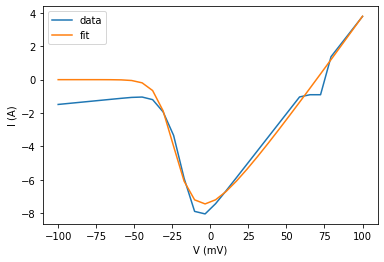

In [15]:
# Fit curve to HH sodium IV plot

v_array = np.linspace(-100,100, num=30)
Im_array = peak_currents/mA

def f_Ca(v, a, b, c, d):
    return(a*(v-b)/(1+exprel((c - v/d))))
           


seed(seed=100)

popt, pcov = curve_fit(f_Ca, v_array, Im_array, method='trf')
print(popt)
plt.plot(v_array, Im_array)
plt.plot(v_array, f_Ca(v_array, *popt))
plt.xlabel('V (mV)')
plt.ylabel('I (A)')
plt.legend(['data','fit'])
